## Deep Learning training with CNN and an extended FastText word embedding
We test here the combination of:
* an embedding layer which is initialized with a pretrained fasttext word embedding extended with custom embedding model
* a CNN layer to capture word sequence representation
* a dense layer to learn classification

We leverage the pre-trained fasttext word embedding model gracefully supplied by Facebook company at [https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)

This general purpose word embedding model is extended with custom model generated by [fasttext_embedding_extension_builder.ipynb](fasttext_embedding_extension_builder.ipynb) script

In [4]:
# Keras
import keras
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
from utils import vizu
from utils import serializer

embeddings_index = {}

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
from sklearn.model_selection import train_test_split

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('../../data/POSOS/label.csv', sep=';')

XTrain, XTest, YTrain, YTest = train_test_split(XTrain, YTrain, test_size=0.15, random_state=42)
num_classes = 51

In [12]:
from keras.preprocessing.sequence import pad_sequences

vocabulary_size = 10000
sequence_length = 30
embedding_out_dims = 300

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(XTrain['question'])

sequences = tokenizer.texts_to_sequences(XTrain['question'])
XEncodedTrain = pad_sequences(sequences, maxlen=sequence_length)

In [13]:
# load the French fasttext model
import os, re, csv, math, codecs
from tqdm import tqdm

if len(embeddings_index) == 0:
    
    f = codecs.open('../../pretrained_models/fasttext/wiki.fr.vec', encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

In [14]:
# complete the embedding mode with the custom one built by the script additional_fasttext_embedding_builder.ipynb
customEmbedding = serializer.loadEmbeddingVector('../../pretrained_models/fasttext_embedding_extension.txt')

for k,v in customEmbedding.items():
    embeddings_index[k] = v 

In [15]:
nb_words = min(vocabulary_size, len(tokenizer.word_index))

embedding_matrix = np.zeros((nb_words+1, embedding_out_dims))

for word, i in tokenizer.word_index.items():
    if i >= nb_words:
        continue
                
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        raise Exception("unknown word=" + word)

###  <b>Build neural network with CNN and FastText embedding<b>

In [32]:
# hyper-parameters
drop_ratio = 0.15
num_filters = 128
hidden_dims = num_filters
kernel_sizes = [4, 6 , 8, 10, 12]
pool_sizes = [10, 10, 10, 10]

batch_size = 24
num_epochs= 100

strides = 1
patience = 20

In [33]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Convolution1D, MaxPooling1D, Dropout, Flatten, Input, Concatenate
from keras.layers.embeddings import Embedding


# tensor flow technical setting
#config = tf.ConfigProto(device_count={"CPU": 32})
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8, allow_growth = True)
config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

# build the neural network

input_layer = Input(shape=(sequence_length, ))

# word embedding loaded from fasttext+extension
embedding_layer = Embedding(
                    input_dim=len(tokenizer.word_index)+1,
                    output_dim=embedding_out_dims,
                    weights=[embedding_matrix],
                    input_length=sequence_length,
                    trainable=False) (input_layer)

dropout_layer_1 = Dropout(drop_ratio) (embedding_layer)

# parallel convolution/pooling/flatten branches with different kernel sizes
conv_blocks = []
for kernel_size, pool_size in zip(kernel_sizes, pool_sizes):
    conv_layer = Convolution1D(
                    filters=num_filters,
                    kernel_size=kernel_size,
                    strides=strides,
                    activation='relu') (dropout_layer_1)
    
    pooling_layer = MaxPooling1D(pool_size=pool_size) (conv_layer)

    flatten_layer = Flatten() (pooling_layer)
    
    conv_blocks.append(flatten_layer)

concat_layer = Concatenate() (conv_blocks)

dropout_layer_2 = Dropout(drop_ratio) (concat_layer)

# classification layer
hidden_dense_layer = Dense(hidden_dims, activation="relu") (dropout_layer_2)

class_dense_layer = Dense(num_classes, activation='softmax') (hidden_dense_layer)

model_conv = Model(input_layer, class_dense_layer)
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_conv.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 30, 300)      2429400     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 30, 300)      0           embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 27, 128)      153728      dropout_11[0][0]                 
__________________________________________________________________________________________________
conv1d_23 

### Train the network

In [18]:
YOneHotEncodedTrain = keras.utils.to_categorical(YTrain['intention'])

In [34]:
# generate the tensorflow board
call_back_board = keras.callbacks.TensorBoard(
    log_dir='c:/git/CES/logs',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    write_grads=True,
    write_images=True,
    embeddings_freq=0,
    embeddings_layer_names=None,
    embeddings_metadata=None,
    embeddings_data=None)

# stop criterion to avoid overfitting
call_back_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=patience,
    verbose=0,
    mode='auto',
    baseline=None)

call_back_reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=patience/2
)

# learn !
model_conv.fit(
    XEncodedTrain,
    np.array(YOneHotEncodedTrain),
    validation_split=0.15,
    epochs = num_epochs,
    batch_size=batch_size,
    verbose=2,
    callbacks = [call_back_early_stopping, call_back_board, call_back_reduce_learning_rate])


Train on 5799 samples, validate on 1024 samples
Epoch 1/100
 - 3s - loss: 3.0515 - acc: 0.2428 - val_loss: 2.7913 - val_acc: 0.2842
Epoch 2/100
 - 3s - loss: 2.3447 - acc: 0.3982 - val_loss: 2.4324 - val_acc: 0.3516
Epoch 3/100
 - 3s - loss: 1.7651 - acc: 0.5322 - val_loss: 2.2387 - val_acc: 0.4473
Epoch 4/100
 - 3s - loss: 1.2886 - acc: 0.6563 - val_loss: 2.2712 - val_acc: 0.4395
Epoch 5/100
 - 3s - loss: 0.9151 - acc: 0.7579 - val_loss: 2.2448 - val_acc: 0.4854
Epoch 6/100
 - 3s - loss: 0.6960 - acc: 0.8117 - val_loss: 2.3078 - val_acc: 0.4717
Epoch 7/100
 - 3s - loss: 0.5542 - acc: 0.8533 - val_loss: 2.4652 - val_acc: 0.4951
Epoch 8/100
 - 3s - loss: 0.4897 - acc: 0.8703 - val_loss: 2.6306 - val_acc: 0.5020
Epoch 9/100
 - 3s - loss: 0.4498 - acc: 0.8796 - val_loss: 2.5578 - val_acc: 0.4941
Epoch 10/100
 - 3s - loss: 0.3765 - acc: 0.8953 - val_loss: 2.5871 - val_acc: 0.4990
Epoch 11/100
 - 3s - loss: 0.3276 - acc: 0.9117 - val_loss: 2.7743 - val_acc: 0.5146
Epoch 12/100
 - 3s - loss:

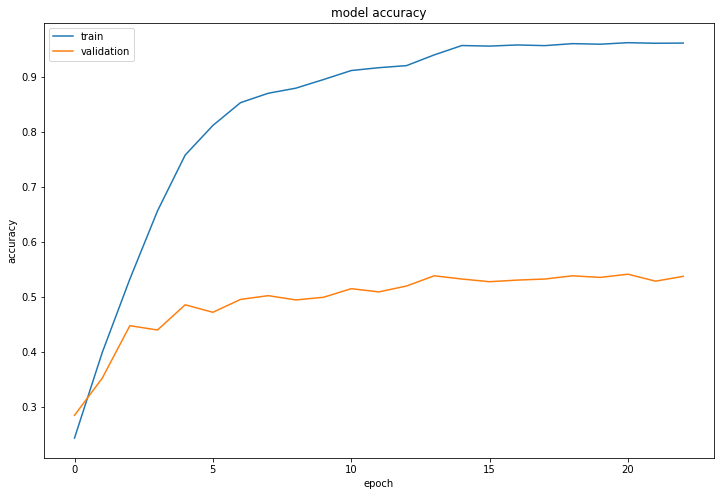

In [35]:
%matplotlib inline

vizu.plot_keras_model_learning_curve(model_conv.history)

In [1]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

testSequences = tokenizer.texts_to_sequences(XTest['question'])
XEncodedTest = pad_sequences(testSequences, maxlen=sequence_length)
    
YTrue = YTest['intention']

YProba = model_conv.predict(XEncodedTest)
YPredicted = YProba.argmax(axis=-1)


cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))

plt.figure(figsize=(20,20))

vizu.plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()

NameError: name 'tokenizer' is not defined